# Find the perfect place to stay in Texas!

In this notebook is analyzed the text of Airbnb property listings and builded a search engine.

First of all we imported all the libraries needed for this purpose.

In [1]:
import numpy as np
import pandas as pd
import csv
import nltk
import string
import re
import os
import json
import matplotlib.pyplot as plt
import folium as fl

In [2]:
from geopy import distance
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from math import log
from math import sqrt
from scipy.stats import chisquare
from sklearn.cluster import KMeans
from heapq import heappush, heappop
from heapq import heappush, heappop

### Data Cleaning Function

It's defined here a data cleaning function, used to clean all the reviews' texts and later on the queries.
A number of steps are performed for the task:
- replace $ with 'dollar', to avoid losing relevant information from the text
- replace new line symbols with whitespace
- remove puntuation
- separate numbers from words
- remove stopwords
- tokenize the text
- stem of the words, just keeping the root

In [3]:
def string_cleaning(string_raw):

    m = re.sub('[$]','dollar',string_raw)
    m = m.replace('\\r', ' ').replace('\\n', ' ')
    m = re.sub('[%s]' % re.escape(string.punctuation), ' ', m)
    m = re.sub(r'(?<=[\d+])(?=[a-zA-Z_])', r' ', m)
    m = nltk.tokenize.word_tokenize(m)
    m = [word for word in m if word.lower() not in stopwords.words('english')]
    sno = nltk.stem.SnowballStemmer('english')
    string_new = [sno.stem(word) for word in m]
    
    return string_new

## Conjunctive query

In [4]:
path, dirs, files = next(os.walk("directory"))
file_count = len(files)

### Creating a full corpus with all the words appeared in the descriptions and the titles

In [5]:
corpus = []
for i in range(file_count):
    filename = 'directory/doc_{}.tsv'.format(i+1)
    with open(filename,encoding='utf8') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        document = []
        for row in reader:
            document.append(row)
        corpus.append(document[4][0] + document[7][0])

For each word in the corpus it's performed the data cleaning and tokenization and the corpus has been flattened for the words' occurrence.

In [6]:
lista = []
for i in range(len(corpus)):
    lista.append(string_cleaning(corpus[i]))
    

lista_flatten = [y for x in lista for y in x]

The next step is to create a dictionary with all the words counted and then sorted by frequency.

In [7]:
c = Counter(lista_flatten)
c= dict(c.most_common())

final_dict = {str(i+1):x for i,x in enumerate(c)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(c)}

### Index  and Inverse Index dictionary

In [8]:
indx = {}
for n,document in enumerate(lista):
    new_document = []
    for word in document:
        new_document.append(final_dict_inv[str(word)])
    indx[str(n+1)] = new_document 
    
inv_indx = {str(i):[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i in range(len(indx)):
        if int(word) in indx[str(i+1)]:
            inv_indx[word].append(i+1)    

For future usage, all the dictionaries are saved and loaded

In [9]:
with open('regular_index.json', 'w') as fp:
    json.dump(indx, fp)

with open('inverted_index.json', 'w') as fp:
    json.dump(inv_indx, fp)
    
with open('words_transformation.json', 'w') as fp:
    json.dump(final_dict, fp)    
    
with open('words_inverse_transformation.json', 'w') as fp:
    json.dump(final_dict_inv, fp) 
    

In [10]:
with open('regular_index.json', encoding='utf-8') as fp:
    indx = json.loads(fp.read())

with open('inverted_index.json', encoding='utf-8') as fp:
    inv_indx = json.loads(fp.read())

with open('words_transformation.json', encoding='utf-8') as fp:
    final_dict = json.loads(fp.read())

with open('words_inverse_transformation.json', encoding='utf-8') as fp:
    final_dict_inv = json.loads(fp.read())

## Execution of the example query

In [11]:
query = 'a beautiful house with garden'

The query has to be clean and the terms are sorted from the less frequent to make the search faster.

In [12]:
q = string_cleaning(query)

q_new = sorted([final_dict_inv[str(element)] for element in q if element in list(final_dict.values())])[::-1]
documents = [inv_indx[str(term)] for term in q_new]
documents_final = set(documents[0])
for l2 in documents[1:]:
    documents_final = documents_final.intersection(set(l2))

Once the search it's done it's needed to give the output.
The only elements reported are Title, Description, City and Url.

In [13]:
cols=['Title','Description','City','Url']
df = pd.DataFrame([])
for i in documents_final:
    filename = 'directory/doc_{}.tsv'.format(i)
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T.loc[:,[7,4,2,8]],ignore_index=True)

if df.empty:
    print('No match found!')
else:
    df.columns = cols
    df.index = list(range(1,len(documents_final)+1))

In [14]:
df.head(10)

,Title,Description,City,Url
1,Dallas Downton Abbey,"Our Dallas Downton Abbey is close to downtown,...",Dallas,https://www.airbnb.com/rooms/14254297?location...
2,Historic Mansion Downtown Ft Worth; Bass Hall;...,"Less than 2 miles from TCU, the Fort Worth Con...",Fort Worth,https://www.airbnb.com/rooms/8664808?location=...
3,Unique Location! Alamo Heights - Designer Insp...,"Stylish, fully remodeled home in upscale NW – ...",San Antonio,https://www.airbnb.com/rooms/17481455?location...
4,The Vintage room in Fort Worth,Our place is a beautiful cozy open concept hou...,Fort Worth,https://www.airbnb.com/rooms/18959678?location...
5,Beautiful queen bedroom in NW Austin,"My house is close to Lakeline Mall, highways a...",Austin,https://www.airbnb.com/rooms/16755710?location...
6,Unique Location! Alamo Heights - Designer Insp...,"Stylish, fully remodeled home in upscale NW – ...",San Antonio,https://www.airbnb.com/rooms/17481455?location...
7,East Austin Hillside Gem,"Beautiful and modern 3Br, 2.5Ba located minute...",Austin,https://www.airbnb.com/rooms/17555039?location...
8,"The Woodlands, BEAUTIFUL HOME, 1 Floor, 2 BT, ...","Attractions: The Woodlands, incredible views, ...",Spring,https://www.airbnb.com/rooms/13065223?location...
9,Stylish Stone Cottage on White Rock Lake,"Newly remodeled, open-concept living located o...",Dallas,https://www.airbnb.com/rooms/15132655?location...
10,"Vintage Airstream in East Austin, T",This fantastic backyard garden oasis has been ...,Austin,https://www.airbnb.com/rooms/949922?location=B...


## Conjunctive query & Ranking score (Cosine Similarity)

Once founded all the documents that contain the words in the query, we want to define a ranking with the cosine similarity to show the users the most relevant documents they could be interested in.

### Cosine Index  and Inverse Cosine Index dictionary

To use the Cosine similarity it's needed to calcolate for each term:
- the frequency in each document: TF
- the IDF$_{i}$ defined has: $$IDF_{i}=\log{\frac{n}{N_{i}}}$$
where i is refered to term i

In [15]:
inv_indx_cosine = {i:[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i,l in enumerate(list(indx.values())):
        if int(word) in l:
            tf = l.count(int(word))/len(l)
            id_f = log(file_count/len(inv_indx[word]))
            inv_indx_cosine[word].append((i+1,tf*id_f))

In [16]:
indx_cosine = {}
for doc in range(file_count):
    indx_cosine[str(doc+1)] = []
    for term in list(final_dict.keys()):
        if int(doc+1) in [r for r in inv_indx[str(term)]]:
            k  = inv_indx[term].index(doc+1)
            indx_cosine[str(doc+1)].append((term,inv_indx_cosine[term][k][1]))

For future usage the index are saved and loaded

In [17]:
with open('inverted_index_cosine.json', 'w') as fp:
    json.dump(inv_indx_cosine, fp)
    
with open('index_cosine.json', 'w') as fp:
    json.dump(indx_cosine, fp)   

In [18]:
with open('inverted_index_cosine.json', encoding='utf-8') as fp:
    inv_indx_cosine = json.loads(fp.read())

with open('index_cosine.json', encoding='utf-8') as fp:
    indx_cosine = json.loads(fp.read())

## Example Query Executing

Given a query, all the documents that contain all the terms are found, as previously

In [19]:
query = 'beautiful house in San Antonio'

q = string_cleaning(query)

q_new = Counter([final_dict_inv[str(element)] for element in q if element in list(final_dict.values())])

documents = [inv_indx[str(term)] for term in q_new]
documents_final = set(documents[0])
for l2 in documents[1:]:
    documents_final = documents_final.intersection(set(l2))

The results are store into a heap data structure.
The similarity between the query and each documents has been calculate as:
$$cos(q,d_{i})=\frac{\sum_{j=0}^n TF_{i}*IDF_{j}}{\left|q\right|*\left|d_{i}\right|}$$
with j refered to the terms in the query and i to the document considered.

In [20]:
similarity = []
for doc in documents_final:
    s = 0
    for term in list(q_new.keys()):
        if doc in inv_indx[str(term)]:  
            k  = inv_indx[str(term)].index(doc)
            s += inv_indx_cosine[str(term)][k][1]*(q_new[term]/len(q_new))
    qm = sqrt(sum([k/len(q_new)**2 for k in q_new.values()]))
    dm = sqrt(sum([k[1]**2 for k in indx_cosine[str(doc)]]))
    heappush(similarity,(s/(sqrt(qm)*sqrt(dm)),doc))

k = 100
for i in range(len(similarity)-k):
    heappop(similarity)    

### Output
All the documents are sorted according to the cosine similarity score.

In [21]:
similarity = sorted(similarity)[::-1]
cols=['Title','Description','City','Url']
df = pd.DataFrame([])
docs = [k[1] for k in similarity]
for i in range(len(docs)):
    filename = 'directory/doc_{}.tsv'.format(docs[i])
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T.loc[:,[7,4,2,8]],ignore_index=True)
df.columns = cols
df['Similarity'] = [k[0] for k in similarity]
df.index = list(range(1,len(df)+1))
df

,Title,Description,City,Url,Similarity
1,Cute two story house in San Antonio,Really nice quiet neighborhood in beautiful Sa...,San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.214126
2,Cute two story house in San Antonio,Really nice quiet neighborhood in beautiful Sa...,San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.214126
3,San Antonio Lake House on Lake LBJ,The San Antonio Lake House is located in the T...,Kingsland,https://www.airbnb.com/rooms/13634952?location...,0.201379
4,San Antonio Lake House on Lake LBJ,The San Antonio Lake House is located in the T...,Kingsland,https://www.airbnb.com/rooms/13634952?location...,0.201379
5,House Nestled in Quiet Neighborhood,I hope you’ll love my place because of the qui...,San Antonio,https://www.airbnb.com/rooms/18568735?location...,0.185773
6,House Nestled in Quiet Neighborhood,I hope you’ll love my place because of the qui...,San Antonio,https://www.airbnb.com/rooms/18568735?location...,0.185773
7,A Cozy Home with a Beautiful Nature Views,"This home is on the North Side of San Antonio,...",San Antonio,https://www.airbnb.com/rooms/19190311?location...,0.160501
8,Blanco River House,River House is just off the square in quaint B...,Blanco,https://www.airbnb.com/rooms/7159265?location=...,0.158954
9,Priv. Room@Beautiful House by La Cantera/Six F...,"- Stay in an Beautiful, relaxing house with gr...",San Antonio,https://www.airbnb.com/rooms/8557583?location=...,0.136170
10,Private room in cozy house.,Come and visit or stay longer here in beautifu...,San Antonio,https://www.airbnb.com/rooms/16507221?location...,0.129963


## Define a new score!
To define a new score other parametres are considered: the location, given by latitude and longitude, the average price per night, the number of bedrooms. A new dataframe with all this information is created.

It's also needed a dictionary with the cities of Texas and their coordinates.

In [22]:
cols=['Average_rate_per_night','Bedrooms_count','City','Date_of_listing','Description','Latitude','Longitude','Title','Url']
df = pd.DataFrame([])
for i in range(file_count):
    filename = 'directory/doc_{}.tsv'.format(i+1)
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols


all_cities = pd.read_csv('uscitiesv1.4.csv')
texas = all_cities[all_cities.state_name=='Texas']

cities_cord = {}
for city in df.City.unique():
    if city in texas.city.values:
        cities_cord[city] = [texas[texas.city == city].lat.iloc[0],texas[texas.city == city].lng.iloc[0]]
        
df.dropna(inplace=True)
lat = df.Latitude.apply(pd.to_numeric,errors='coerce').values
long = df.Longitude.apply(pd.to_numeric,errors='coerce').values
X = [[l1,l2] for l1,l2 in zip(lat,long)]

To consider the different locations we decided to cluster them in 10 main areas.
<br>
First it's created a KMEANS clustering.
<br>
Then it's shown in a plot how the differt areas are divided.

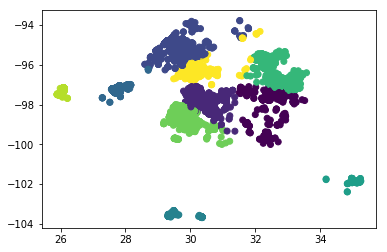

In [23]:
kmeans = KMeans(n_clusters=10).fit(X)


%matplotlib inline
plt.scatter(lat,long,c=kmeans.labels_)

## Example query execution

From the user is now required a query, as previously, and some more informations: average price per night, number of bedrooms needed, location.
<br>
Through the dictionary or geolocator library the coordinates are obtained.


The first part of the search is done as before.

In [24]:
query = 'beautiful house in San Antonio'
qprice = 60 
qrooms = 2
qarea = 'San Antonio'

if qarea in cities_cord.keys(): 
    la,lo = cities_cord[qarea]
else:
    from geopy.geocoders import Nominatim
    geolocator = Nominatim()
    la,lo = geolocator.geocode(qarea + " US")[-1]
qarea = kmeans.predict([[la,lo]])[0]+1 
q_values = [qprice/150,qrooms/10,qarea/10,la/30,lo/100]  


q = string_cleaning(query)
q_new = sorted([final_dict_inv[str(element)] for element in q if element in list(final_dict.values())])[::-1]
documents = [inv_indx[str(term)] for term in q_new]
documents_final = set(documents[0])
for l2 in documents[1:]:
    documents_final = documents_final.intersection(set(l2))


## Finding Results

The documents containg each term are loaded.
<br>
The columns are cleaned and numerized.
<br>
At last is created a matrix in order to apply chi-square statistics to each row of it.

In [25]:
df = pd.DataFrame([])
for i in documents_final:
    filename = 'directory/doc_{}.tsv'.format(i)
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols
df.index = list(range(1,len(documents_final)+1))

df.Bedrooms_count.replace('Studio',1,inplace=True)

#Columns cleaning and numerization
price = df.Average_rate_per_night.str.split('$').str[-1].apply(pd.to_numeric).values
rooms = df.Bedrooms_count.apply(pd.to_numeric,errors='coerce').values
lat = df.Latitude.apply(pd.to_numeric,errors='coerce').values
long = df.Longitude.apply(pd.to_numeric,errors='coerce').values
lat = np.nan_to_num(lat)
long = np.nan_to_num(long)
X = [[l1,l2] for l1,l2 in zip(lat,long)]
cities = [kmeans.predict(X)][0]+1 

#Final Matrix
matrix = np.array([price/150,rooms/10,cities/10,lat/30,long/100]).T
matrix

array([[ 0.86666667,  0.3       ,  0.8       ,  0.98588211, -0.98381229],
       [ 1.33333333,  0.3       ,  1.        ,  0.99034007, -0.96539676],
       [ 0.67333333,  0.1       ,  0.8       ,  0.98902128, -0.98658216],
       [ 0.56666667,  0.3       ,  0.8       ,  0.98174469, -0.98510782],
       [ 0.73333333,  0.1       ,  0.8       ,  0.98896771, -0.98418352],
       [ 1.54666667,  0.3       ,  0.8       ,  0.98919173, -0.9813502 ],
       [ 2.79333333,  0.5       ,  0.8       ,  0.98616125, -0.98660127],
       [ 0.3       ,  0.1       ,  0.8       ,  0.98707973, -0.98616689],
       [ 2.5       ,  0.3       ,  0.8       ,  1.00312822, -0.98410653],
       [ 1.33333333,  0.3       ,  1.        ,  0.99034007, -0.96539676],
       [ 1.83333333,  0.3       ,  0.2       ,  1.01881093, -0.98281663],
       [ 0.43333333,  0.2       ,  0.8       ,  0.98217756, -0.98353234],
       [ 2.89333333,  0.2       ,  0.2       ,  1.02179612, -0.98433686],
       [ 0.24666667,  0.1       ,  0.8

#### Apply chi-square statistics test and heappushing of the data

For each document is given a score with the chi-square method.
<br>
Again the top-k documents are stored in a heap data structure.

In [26]:
score = []
for i in range(matrix.shape[0]):
    heappush(score,(chisquare(q_values,f_exp=matrix[i])[-1],list(documents_final)[i]))  
    
k = 100
score = sorted(score)[::-1]
for i in range(len(score)-k):
    heappop(score)
    

The top-k documents are given as output for the user.

In [27]:
df = pd.DataFrame([])
score = sorted(score)[::-1]
docs = [k[1] for k in score]
for i in range(len(docs)):
    filename = 'directory/doc_{}.tsv'.format(docs[i])
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols
df['Ranking'] = [k[0] for k in score]
df['Latitude'] = df['Latitude'].astype('float64')
df['Longitude'] = df['Longitude'].astype('float64')
df.index = list(range(1,len(df)+1))
df

,Average_rate_per_night,Bedrooms_count,City,Date_of_listing,Description,Latitude,Longitude,Title,Url,Ranking
1,$65,2,San Antonio,July 2015,I hope you’ll love my place because of the qui...,29.465327,-98.353234,House Nestled in Quiet Neighborhood,https://www.airbnb.com/rooms/18568735?location...,0.999999
2,$65,2,San Antonio,July 2015,I hope you’ll love my place because of the qui...,29.465327,-98.353234,House Nestled in Quiet Neighborhood,https://www.airbnb.com/rooms/18568735?location...,0.999999
3,$85,3,San Antonio,March 2017,Our charming home with vintage and contemporar...,29.452341,-98.510782,Gorgeous Eclectic House.,https://www.airbnb.com/rooms/18396644?location...,0.999175
4,$85,3,San Antonio,March 2017,Our charming home with vintage and contemporar...,29.452341,-98.510782,Gorgeous Eclectic House.,https://www.airbnb.com/rooms/18396644?location...,0.999175
5,$45,1,San Antonio,April 2015,"- Stay in an Beautiful, relaxing house with gr...",29.612392,-98.616689,Priv. Room@Beautiful House by La Cantera/Six F...,https://www.airbnb.com/rooms/8557583?location=...,0.997873
6,$37,1,San Antonio,December 2016,Come and visit or stay longer here in beautifu...,29.502868,-98.650763,Private room in cozy house.,https://www.airbnb.com/rooms/16507221?location...,0.995531
7,$101,1,San Antonio,June 2016,"Beautifully decorated cottage. Quaint, cozy, a...",29.670638,-98.658216,Sandra's Cottage w/Pool (Centrally Located!),https://www.airbnb.com/rooms/13299372?location...,0.994811
8,$110,1,San Antonio,June 2017,"This home is on the North Side of San Antonio,...",29.669031,-98.418352,A Cozy Home with a Beautiful Nature Views,https://www.airbnb.com/rooms/19190311?location...,0.992723
9,$130,3,San Antonio,October 2011,Really nice quiet neighborhood in beautiful Sa...,29.576463,-98.381229,Cute two story house in San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.990785
10,$130,3,San Antonio,October 2011,Really nice quiet neighborhood in beautiful Sa...,29.576463,-98.381229,Cute two story house in San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.990785


## Bonus Step: Make a nice visualization!

The user could make a search by location. In that case we want to show all the place avaible on an area with a radius given from the user.
<br>
As an example the user can give a location and a distance to consider.


In [28]:
df['Latitude'] = df['Latitude'].astype('float64')
df['Longitude'] = df['Longitude'].astype('float64')

la,lo = ((29.4722, -98.5247))
pos = []

for lat, long in zip(df.Latitude, df.Longitude): 
    tmp = [] 
    tmp.append(lat)
    tmp.append(long)
    pos.append(tmp) 
    
dist = 50   #in kms

The final step is to create a map where is shown the location given by the user and all the places found from the search.
<br>
To better visualize the area it's shown a circle of the considered area.

In [29]:
m = fl.Map(location=[la, lo], zoom_start=12)

for n,loc in enumerate(pos):
    dis = distance.distance([la, lo], loc).km 
    fl.Marker([la, lo], icon=fl.Icon(color='red')).add_to(m)
    if dis <= dist:
        fl.Marker(loc, tooltip=df['Average_rate_per_night'][n+1]).add_to(m)


fl.Circle(
    location=[la, lo],
    radius=dist*1000, 
    fill=True,
    fill_color='#3186cc'
).add_to(m)
m

In [30]:
m.save('my_map.html')